In [25]:
%load_ext autoreload
%autoreload 2

import sys
import time
sys.path.insert(0, '../')

# import embedding methods
from embedding.bernoulli import Bernoulli
from embedding.kl import KL
from embedding.matrix_factorization import MatrixFactorization

# import evaluation methods
from evaluation import evaluate_link_prediction
from evaluation import evaluate_node_classification
from evaluation import evaluate_node_classification_christos
from evaluation import evaluate_node_clustering
# 
# import utils
from utils import graph_util
from utils import plot_util
from utils import model_util


import seaborn as sns

sns.set_style('whitegrid')
# visualization
%matplotlib inline
#sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The results of the current experiment are stored at experiments/results/2019_12_30_14_37
	Node clustering evaluation has started...
Epoch    0, loss = 18778592.00000
[5 2 0 ... 2 2 2] [5 3 3 ... 5 6 0]
0
Epoch    0, loss = 18776152.00000
[5 2 0 ... 2 2 2] [5 4 3 ... 6 1 1]
1
[0.004292452560136027, 0.00418910282240667]
Model evaluation took: 10.574174404144287 seconds
	Node clustering evaluation has started...
Epoch    0, loss = 27728928.00000
[5 2 0 ... 2 2 2] [3 3 3 ... 5 0 4]
0
Epoch    0, loss = 27849336.00000
[5 2 0 ... 2 2 2] [5 4 3 ... 5 2 1]
1
[0.004681587849409977, 0.0036059620263332944]
Model evaluation took: 2.0537619590759277 seconds
	Node clustering evaluation has started...
Epoch    0, loss = 11536997.00000
[1 4 4 ... 3 1 1] [1 0 4 ... 0 1 2]
0
Epoch    0, loss = 11538047.00000
[1 4 4 ... 3 1 1] [0 1 2 ... 0 0 0]
1
[0.006443091245695059, 0.006289324552865128]
Model evaluation took: 1.8271245956420898 seconds
	Node clustering evaluation has started...
Epoch    0, loss = 170

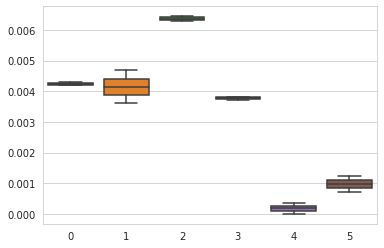

In [26]:
# Experiment 1

exp = {
    "max_epochs": 500,
    "learning_rate": 1e-2, #Adam
    "weight_decay": 1e-7,
    
    "link_prediction": False,
    "link_pred_num_rounds": 2,
    "link_pred_train_ratio": 0.8,
    "link_pred_eval_every_n_steps": 5,
    "link_pred_edge_emb_method": "average",
    
    "node_classification": False,
    "node_class_num_rounds": 2,
    "node_class_train_ratio": 0.8,
    "node_class_eval_every_n_steps": 5,
    
    "node_clustering": True,
    "node_clustering_num_rounds": 2,
    "node_clustering_eval_every_n_steps": 5,
    
}

# pick datasets
datasets = ["cora", "citeseer", "polblogs"] # parliament, hvr, purdue_facebook

model_01 = Bernoulli(embedding_dimension=64, decoder='sigmoid')
model_02 = Bernoulli(embedding_dimension=64, decoder='gaussian')
model_03 = Bernoulli(embedding_dimension=64, decoder='exponential')

model_04 = KL(embedding_dimension=64, decoder='sigmoid', similarity_measure='adjacency')
model_05 = KL(embedding_dimension=64, decoder='exponential',similarity_measure='adjacency')
model_06 = KL(embedding_dimension=64, decoder='gaussian',similarity_measure='adjacency')
model_07 = KL(embedding_dimension=64, decoder='sigmoid',similarity_measure='laplacian')
model_08 = KL(embedding_dimension=64, decoder='exponential',similarity_measure='laplacian')
model_09 = KL(embedding_dimension=64, decoder='gaussian',similarity_measure='laplacian')
model_10 = KL(embedding_dimension=64, decoder='sigmoid', similarity_measure='dw')
model_11 = KL(embedding_dimension=64, decoder='exponential',similarity_measure='dw')
model_12 = KL(embedding_dimension=64, decoder='gaussian',similarity_measure='dw')

model_13 = MatrixFactorization(embedding_dimension=64, similarity_measure='adjacency')
model_14 = MatrixFactorization(embedding_dimension=64, similarity_measure='laplacian')
model_15 = MatrixFactorization(embedding_dimension=64, similarity_measure='dw')

total_NMI = []

embedding_methods = [model_04, model_05]# model_03]

#model_01, model_03, model_04, model_06, 

# embedding_methods = [model_13, model_14, model_15]

# setup folders to store experiment setup summary and results
result_folder = plot_util.setup_folders_and_summary_files(exp, datasets, embedding_methods)
print(f'The results of the current experiment are stored at experiments/{result_folder}')

for dataset in datasets:
    
    # load dataset
    A, y = graph_util.load_dataset(dataset)
    
    
    for model in embedding_methods:
        start = time.time()
        # do link prediction
        if(exp["link_prediction"]):
            link_prediction_folder = result_folder + "/link_prediction"
            evaluate_link_prediction.expLP(A,dataset,model,exp["link_pred_num_rounds"],
                                           link_prediction_folder, train_ratio=exp["link_pred_train_ratio"], 
                                           edge_emb_method=exp["link_pred_edge_emb_method"],train_epochs=exp["max_epochs"],
                                           eval_epochs=exp["link_pred_eval_every_n_steps"], undirected=True)
            
        # do node classification
        if(exp["node_classification"]):
            node_classification_folder = result_folder + "/node_classification"
            evaluate_node_classification_christos.exp_Node_Classification(A,y,dataset,model,exp["node_class_num_rounds"],
                                               node_classification_folder, train_ratio=exp["node_class_train_ratio"],
                                               eval_epochs=exp["node_class_eval_every_n_steps"],undirected=True)
        
            
        # do node clustering classification
        if(exp["node_clustering"]):
            node_clustering_folder = result_folder + "/node_clustering"
            NMI = evaluate_node_clustering.exp_Node_Clustering(A,y,dataset,model,exp["node_clustering_num_rounds"],
                                           node_clustering_folder ,eval_epochs=exp["node_clustering_eval_every_n_steps"],undirected=True)
            print(NMI)
            total_NMI.append(NMI)
        end = time.time()
        end = time.time()
        print(f'Model evaluation took: {end-start} seconds')
        
sns.boxplot(data= total_NMI)